# Clasificación de curvas de acuerdo a su forma utilizando aprendizaje no supervisado


En este cuaderno de trabajo, se aplicarán algoritmos de **aprendizaje no supervisado** para la clasificación de curvas de carga representativas de clientes. Previamente, se realizó un **proceso ETL** en el que se consolidaron datos de múltiples clientes en un único conjunto de datos anual. Estos datos fueron almacenados en **MongoDB** y contienen mediciones de potencia aparente cada **30 minutos**, desde las **00:00 hasta las 23:30**.

El objetivo principal de este análisis es **agrupar las curvas de carga según su forma**, sin que influya el desplazamiento en el eje Y. Para ello, se realizarán una serie de transformaciones y ajustes antes de aplicar los algoritmos de clustering.

### Algoritmos de Clustering Utilizados
Se han seleccionado los siguientes algoritmos de **aprendizaje no supervisado**:

- **K-Means** 🟢  
- **Gaussian Mixture Model (GMM)** 🔵  
- **BIRCH** 🟡  
- **Spectral Clustering** 🟣  

Cada uno de estos algoritmos se ajustará y evaluará para determinar cuál realiza una mejor agrupación de las curvas según su forma.

---

### 0.- Librerías y Funciones a Utilizar  

Se importan las librerías necesarias para el procesamiento de datos, visualización y clustering.

- Librerías Principales  
    - `numpy`, `pandas` → Manejo y transformación de datos.  
    - `matplotlib` → Gráficos y visualización.  
    - `sklearn` → Algoritmo de clustering y métricas.  
    - `pymongo` → Conexión con MongoDB.  

- Algoritmos de Clustering  
    - `KMeans`, `GaussianMixture`, `BIRCH`, `SpectralClustering`.  

- Funciones Auxiliares  
    - Ajuste de curvas al origen *(0,0)*.  
    - Visualización de resultados.
    - Hyperparametrización para los algoritmos
    - Agrupación para cada tipo de algoritmos
    - Evaluar calidad de las agrupaciones

In [1]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import SpectralClustering, KMeans, Birch
from sklearn.mixture import GaussianMixture
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pymongo import MongoClient
from dotenv import load_dotenv
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore")

In [2]:
def obtener_cliente_db():
    # Cargar las variables del archivo .env
    load_dotenv()

    # Obtener las credenciales y el cluster de MongoDB
    username = os.getenv("DB_USER_T")
    password = os.getenv("DB_PASS_T")
    cluster = os.getenv("DB_CLUSTER_T")

    # Construir la uri con las credenciales
    uri = f"mongodb+srv://{username}:{password}@{cluster.lower()}.gypwd.mongodb.net/?retryWrites=true&w=majority&appName={cluster}"

    # Crear un cliente y conectarlo al servidor
    client = MongoClient(uri, 
                        server_api=ServerApi('1'),
                        connectTimeoutMS=60000,
                        socketTimeoutMS=60000,
                        serverSelectionTimeoutMS=60000,
                        tls=True)

    # Si el cliente existe, retornarlo
    if client is not None:
        return client

In [3]:
def ajustar_curva_al_origen(datos_curvas):

    # Crear una copia del arreglo original de las curvas
    curvas_ajustadas = datos_curvas.copy()

    # Iterar sobre cada curva
    for curva in curvas_ajustadas:
        # Obtener el primer dato de cada curva
        primer_dato = curva[0]

        # Modificar los datos de la curva para que el primero siempre empiece en (0,0)
        for i in range(len(curva)):
            curva[i] = curva[i] - primer_dato

    # Retornar todas las curvas con el ajuste realizado
    return curvas_ajustadas

In [4]:
def graficar_clusters(curves_data, labels, n=5):
    unique_clusters = np.unique(labels)
    
    # Crear una figura con el número de subgráficos correspondientes al número de clústeres
    fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(8, 3.5 * len(unique_clusters)), sharex=True)
    
    if len(unique_clusters) == 1:
        axes = [axes]  # Si solo hay un clúster, hacer que axes sea iterable para mantener el formato
    
    # Para cada clúster, graficar las curvas
    for idx, cluster in enumerate(unique_clusters):
        # Seleccionar las curvas pertenecientes al clúster
        curvas_cluster = curves_data[labels == cluster]

        # Tomar hasta 'n' curvas para graficar
        curvas_a_graficar = curvas_cluster[:min(n, len(curvas_cluster))]
        
        for curva in curvas_a_graficar:
            axes[idx].plot(curva, alpha=0.7, linestyle='--')  # Graficar cada curva con transparencia

        axes[idx].set_title(f'Curvas agrupadas en el Clúster {cluster}')
        axes[idx].set_xlabel('Hora del día')
        axes[idx].set_ylabel('Potencia aparente escalada')
        axes[idx].set_yticks(np.arange(0, 1, 0.1))
        axes[idx].grid(True)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

def graficar_curva_tipo_cluster(curves_data, labels):
    unique_clusters = np.unique(labels)
    
    # Crear una figura con el número de subgráficos correspondientes al número de clústeres
    fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(8, 3.5 * len(unique_clusters)), sharex=True)
    
    if len(unique_clusters) == 1:
        axes = [axes]  # Si solo hay un clúster, hacer que axes sea iterable para mantener el formato

    # Para cada clúster, graficar la curva media
    for idx, cluster in enumerate(unique_clusters):
        # Seleccionar las curvas pertenecientes al clúster
        curvas_cluster = curves_data[labels == cluster]

        # Calcular la curva media
        curva_media = np.mean(curvas_cluster, axis=0)

        axes[idx].plot(curva_media, linestyle=None, marker='.')  # Graficar la curva media

        axes[idx].set_title(f'Curva tipo para clientes agrupados en clúster {cluster}')
        axes[idx].set_xlabel('Hora del día')
        axes[idx].set_ylabel('Potencia aparente escalada')
        axes[idx].set_yticks(np.arange(0, 1, 0.1))
        axes[idx].grid(True)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

In [5]:
def evaluate_clustering_models(data, param_grid):
    best_models = {}
    results = []

    for model_name, params in param_grid.items():
        param_combinations = list(product(*params.values()))
        param_keys = list(params.keys())

        best_score = -1
        best_params = None
        best_model = None

        for param_set in param_combinations:
            param_dict = dict(zip(param_keys, param_set))

            # Crear el modelo según su tipo
            if model_name == "KMeans":
                model = KMeans(**param_dict, random_state=41)
            elif model_name == "GaussianMixture":
                model = GaussianMixture(**param_dict, random_state=41)
            elif model_name == "BIRCH":
                model = Birch(**param_dict)
            elif model_name == "SpectralClustering":
                model = SpectralClustering(**param_dict, random_state=41)

            # Entrenar el modelo y obtener etiquetas
            try:
                labels = model.fit_predict(data)

                # Calcular métricas
                silhouette = silhouette_score(data, labels)
                calinski_harabasz = calinski_harabasz_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)

                # Guardar resultados
                results.append((model_name, param_dict, silhouette, calinski_harabasz, davies_bouldin))

                # Actualizar mejor modelo basado en Silhouette Score (puedes cambiar este criterio)
                if silhouette > best_score:
                    best_score = silhouette
                    best_params = param_dict
                    best_model = model

            except:
                continue  # Si hay error, seguimos con la siguiente combinación

        # Guardar el mejor modelo para este tipo
        best_models[model_name] = {
            "model": best_model,
            "params": best_params,
            "silhouette_score": best_score
        }

    return best_models, results


In [6]:
def apply_clustering(parametros_opt, datos_curvas, num_random_state=42):
    # Función para aplicar clustering
    kmeans = KMeans(**parametros_opt["KMeans"], random_state=num_random_state).fit(datos_curvas)
    gmm = GaussianMixture(**parametros_opt["GaussianMixture"], random_state=num_random_state).fit(datos_curvas)
    birch = Birch(**parametros_opt["Birch"]).fit(datos_curvas)
    spectral = SpectralClustering(**parametros_opt["Spectral"], random_state=num_random_state, assign_labels='kmeans').fit(datos_curvas)
    
    return {
        'KMeans': kmeans.labels_,
        'GaussianMixture': gmm.predict(datos_curvas),
        'Birch': birch.labels_,
        'Spectral': spectral.labels_
    }

In [7]:
def evaluar_clustering(curvas_ajustadas_origen, clusters):
    resultados = {"Métrica": ["Silhouette Score", "SSE", "Davies-Bouldin Index", "Calinski-Harabasz Index"]}
    
    for algoritmo, labels in clusters.items():
        labels = np.array(labels)  
        
        silhouette_avg = silhouette_score(curvas_ajustadas_origen, labels)
        dbi = davies_bouldin_score(curvas_ajustadas_origen, labels)
        chi = calinski_harabasz_score(curvas_ajustadas_origen, labels)
        
        unique_labels = np.unique(labels)
        centroids = np.array([curvas_ajustadas_origen[labels == lbl].mean(axis=0) for lbl in unique_labels])
        sse = compute_sse(curvas_ajustadas_origen, labels, centroids)
        
        resultados[algoritmo] = [silhouette_avg, sse, dbi, chi]
    
    return pd.DataFrame(resultados)

def compute_sse(X, labels, centroids):
    sse = 0
    for i in range(len(centroids)):
        cluster_points = X[np.array(labels) == i]
        if len(cluster_points) > 0:
            sse += np.sum((cluster_points - centroids[i]) ** 2)
    return sse

In [47]:
def elbow_method(data, k_range=(1, 10)):
    """
    Aplica el método del codo y grafica la inercia para diferentes valores de k.
    
    Parámetros:
        data (array-like): Datos a agrupar.
        k_range (tuple): Rango de valores de k a evaluar (mínimo, máximo).
    """
    ks = list(range(k_range[0], k_range[1] + 1))
    inertias = []
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=1, init="k-means++")
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    _ = plt.figure(figsize=(12, 6))
    _ = plt.plot(ks, inertias, marker='o', linestyle='-')
    _ = plt.xticks(np.arange(1, k_range[1]+1, 1))
    _ = plt.xlabel('Número de Clústeres (k)')
    _ = plt.ylabel('Inercia')
    _ = plt.grid()
    _ = plt.title('Método del Codo')
    _ = plt.show()

### 1.- Obtención y Preprocesamiento de Datos
- **Obtención de datos** desde la base de datos MongoDB.
- **Ajuste de curvas** para que todas comiencen desde el punto origen **(0,0)**.  
   - Esto es importante porque algunas curvas, aunque tienen la misma forma, están desplazadas en el eje Y (potencia aparente), lo que podría afectar la agrupación.

Nota: Los datos de las curvas ya fueron **normalizados** y **escalados** cuando se realizó previamente el proceso ETL.

In [8]:
# Obtener cliente para conectar a la db
db_cliente = obtener_cliente_db()

# Obtener los registros de las curvas
cursor = db_cliente.CurvasTipo.CurvasTipo_30m.find({}, {"_id": 0})
df_registros_curvas = pd.DataFrame(list(cursor))
df_registros_curvas

,Cliente,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,...,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30
0,1573720,0.363002,0.331695,0.326874,0.325933,0.323621,0.321635,0.321419,0.316180,0.312310,...,0.449903,0.432212,0.416207,0.403184,0.389191,0.386608,0.382731,0.377707,0.372261,0.366060
1,1105013,0.005635,0.005638,0.005625,0.005599,0.005641,0.005603,0.005723,0.005566,0.005681,...,0.013831,0.018898,0.013625,0.007781,0.006178,0.005663,0.005631,0.005546,0.005522,0.005591
2,1526607,0.013584,0.009704,0.011413,0.011141,0.011416,0.011610,0.013109,0.014883,0.014283,...,0.152618,0.109653,0.076575,0.067731,0.059837,0.055541,0.044980,0.036912,0.026697,0.018961
3,730664,0.082170,0.062268,0.063056,0.064055,0.064957,0.065565,0.065585,0.065628,0.066157,...,0.250105,0.229761,0.216083,0.210663,0.204582,0.179754,0.159204,0.118550,0.086001,0.085839
4,1627579,0.411751,0.369310,0.363768,0.328309,0.304045,0.280685,0.300073,0.316729,0.354909,...,0.417470,0.417692,0.420252,0.414043,0.411301,0.408581,0.412699,0.419369,0.414996,0.411478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,PLANTAS TECNICAS PLANTEC,0.743419,0.736625,0.733471,0.725601,0.724044,0.724137,0.722159,0.721879,0.721760,...,0.752499,0.761647,0.759183,0.759199,0.757987,0.754864,0.748818,0.746688,0.747010,0.745319
383,PLASTISACKS (Punto 2),0.398338,0.386867,0.396070,0.395888,0.394678,0.381221,0.378709,0.384696,0.385036,...,0.344806,0.339009,0.383922,0.394191,0.385541,0.391837,0.393133,0.388121,0.385626,0.393935
384,PROVEFARMA - FYBECA,0.632775,0.520884,0.459899,0.419739,0.378865,0.351146,0.332676,0.313714,0.308495,...,0.768608,0.774897,0.769014,0.776480,0.767294,0.745386,0.729979,0.714406,0.710694,0.705524
385,SOCIEDAD INDUSTRIAL RELI CYRANO,0.522447,0.533413,0.594090,0.619295,0.542844,0.474003,0.453784,0.474405,0.424981,...,0.228917,0.220160,0.220309,0.217405,0.226077,0.253856,0.331315,0.413486,0.496200,0.534456


In [9]:
curves_data = df_registros_curvas.iloc[:,1:].values
curves = df_registros_curvas.values

In [10]:
curvas_ajustadas_origen = ajustar_curva_al_origen(curves_data)

### 2.- Método del Codo para Número Óptimo de Clústers

Se ha definido inicialmente **4 clústers**, ya que se identificaron cuatro formas representativas en las curvas anuales. Sin embargo, para validar esta elección, se aplicará el **método del codo**.

Pasos:
- Ejecutar **K-Means** para distintos valores de \( k \) (2 a 20).
- Calcular la **Suma de Errores Cuadráticos (SSE)**.
- Graficar la curva **SSE vs. \( k \)** y detectar el "codo".

Este análisis permitirá verificar si 4 realmente es un número adecuado o si es necesario ajustarlo.

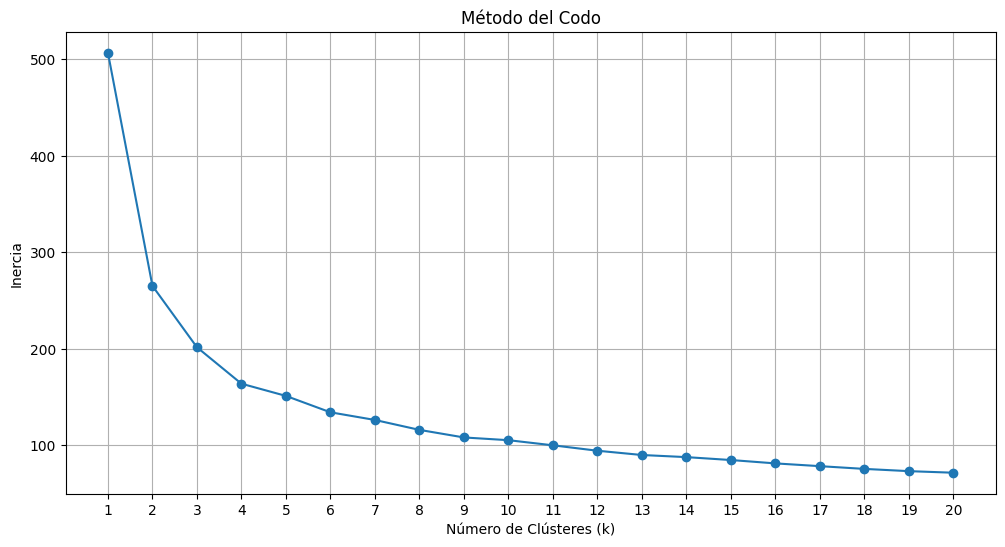

In [48]:
elbow_method(curvas_ajustadas_origen, k_range=(1, 20))

Como se pude apreciar, a partir de k=4, la inercia comienza a minimizarse, formando una especie de 'codo', por lo que podemos asegurar que es un valor bueno e incluso óptimo para el número de agrupaciones que vamos a realizar.

### 3.- Optimización de Hiperparámetros
Para seleccionar los mejores parámetros para cada algoritmo, se definirá un **diccionario de hiperparámetros**, donde:

- Cada clave representa un algoritmo.
- Cada valor es un conjunto de parámetros que puede tomar dicho algoritmo.

Se explorarán combinaciones de hiperparámetros para encontrar la configuración **óptima**.

In [27]:
# Definir los hiperparámetros a probar por cada algoritmo de agrupación
param_grid = {
    "KMeans": {
        "n_clusters": [4],
        "init": ["k-means++", "random"],
        "n_init": [1, 5, 10, 20, 30, 40, 50]
    },
    "GaussianMixture": {
        "n_components": [4],
        "covariance_type": ["full", "diag", "spherical", "tied"],
        "n_init": [1, 5, 10, 20, 30]
    },
    "BIRCH": {
        "n_clusters": [4],
        "threshold": [0.1, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2],
        "branching_factor": [10, 20, 30, 40, 50, 75, 100]
    },
    "SpectralClustering": {
        "n_clusters": [4],
        "affinity": ["nearest_neighbors"],
        "n_neighbors": [4, 6, 8, 10, 15, 25, 35, 50, 60],
        "eigen_solver": ["arpack", "lobpcg", "amg"]
    }
}


In [28]:
best_models, results = evaluate_clustering_models(curvas_ajustadas_origen, param_grid)

In [29]:
for model_name, info in best_models.items():
    print(f"Mejor configuración para {model_name}:")
    print(f"- Parámetros: {info['params']}")
    print(f"- Silhouette Score: {info['silhouette_score']:.4f}")
    print("")


Mejor configuración para KMeans:
- Parámetros: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 1}
- Silhouette Score: 0.3752

Mejor configuración para GaussianMixture:
- Parámetros: {'n_components': 4, 'covariance_type': 'full', 'n_init': 1}
- Silhouette Score: 0.3415

Mejor configuración para BIRCH:
- Parámetros: {'n_clusters': 4, 'threshold': 0.17, 'branching_factor': 10}
- Silhouette Score: 0.3871

Mejor configuración para SpectralClustering:
- Parámetros: {'n_clusters': 4, 'affinity': 'nearest_neighbors', 'n_neighbors': 6, 'eigen_solver': 'arpack'}
- Silhouette Score: 0.3014



### 4.- Aplicación de los Algoritmos de Clustering
Una vez seleccionados los hiperparámetros óptimos, se procederá a **agrupar las curvas** con cada algoritmo y se analizarán los resultados.

In [30]:
dict_parametros_optimos = {
    "KMeans": {'n_clusters': 4, 'init': 'k-means++', 'n_init': 1},
    "GaussianMixture": {'n_components': 4, 'covariance_type': 'full', 'n_init': 1},
    "Birch": {'n_clusters': 4, 'threshold': 0.17, 'branching_factor': 50},
    "Spectral": {'n_clusters': 4, 'affinity': 'nearest_neighbors', 'n_neighbors': 6, 'eigen_solver': 'arpack'}
}

In [31]:
clusters = apply_clustering(dict_parametros_optimos, curvas_ajustadas_origen)

In [33]:
print(np.bincount(clusters["KMeans"]))
print(np.bincount(clusters["GaussianMixture"]))
print(np.bincount(clusters["Birch"]))
print(np.bincount(clusters["Spectral"]))

[115 197  19  56]
[108 207  19  53]
[ 40  19 217 111]
[136 159  71  21]


### 5.- Visualización de Resultados
Para interpretar las agrupaciones, se utilizarán dos funciones de visualización:

- **Curva representativa por clúster**  
   - Se graficará una curva promedio o representativa por cada grupo identificado.

- **Gráfico con todas las curvas de cada clúster**  
   - Se visualizarán todas las curvas pertenecientes a un mismo clúster en un solo gráfico para evaluar la cohesión de los grupos formados.

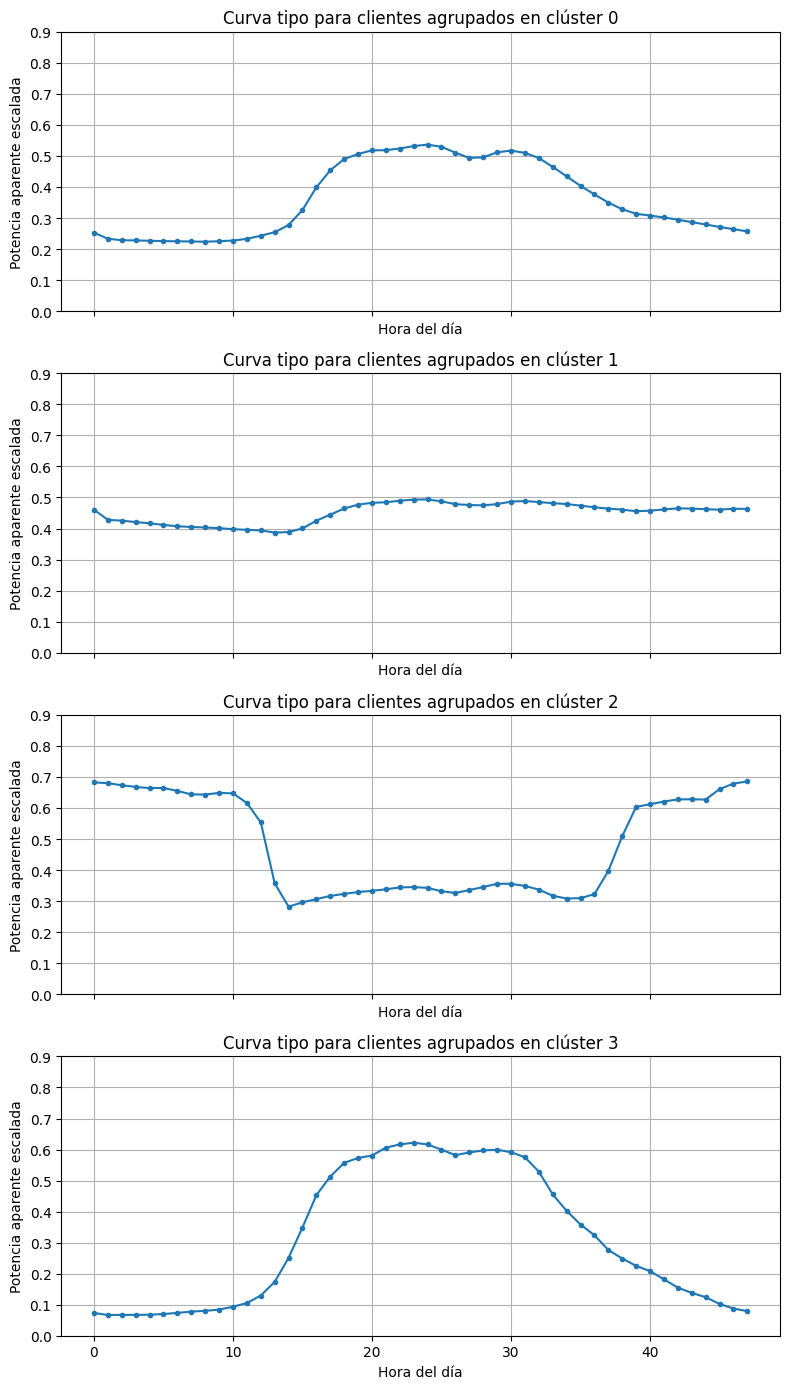

In [35]:
graficar_curva_tipo_cluster(curves_data, clusters["KMeans"])

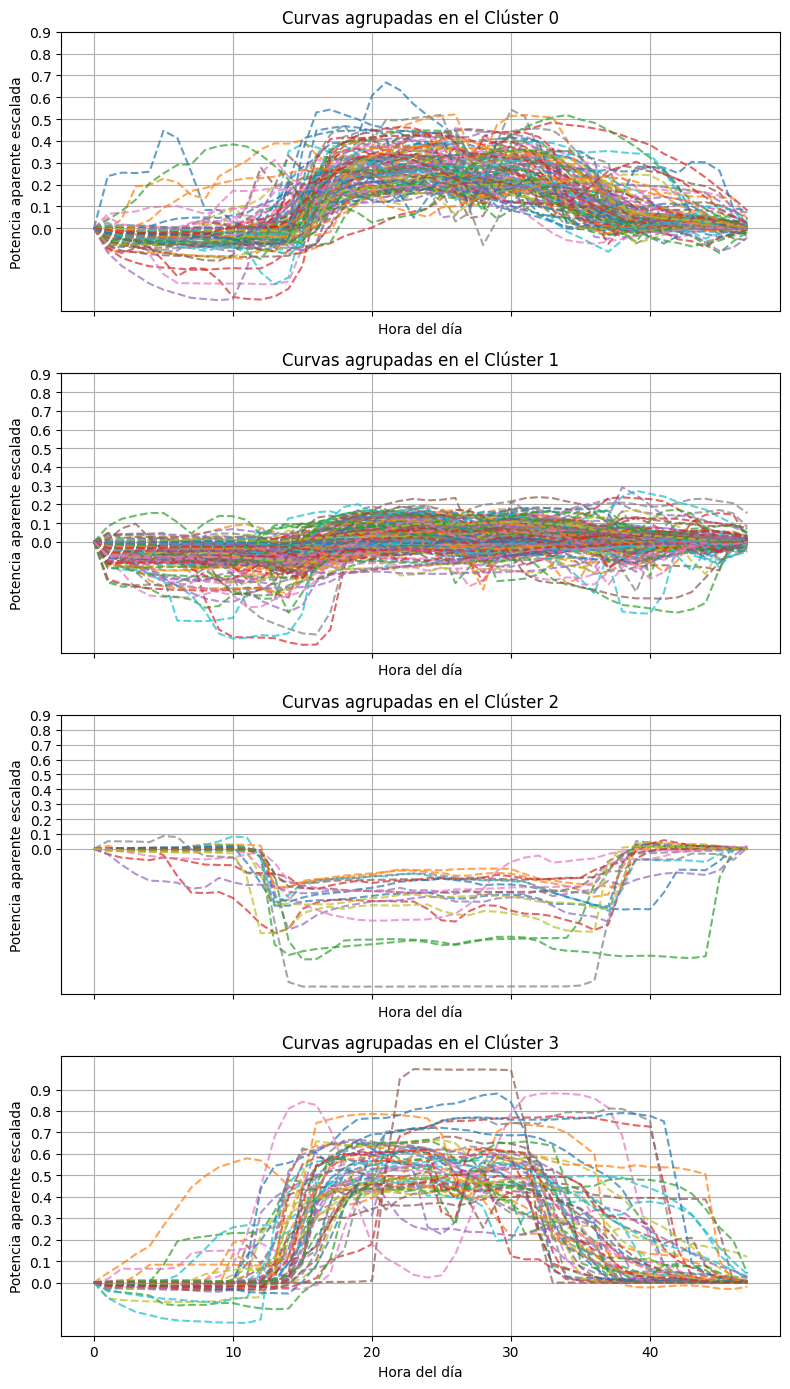

In [36]:
graficar_clusters(curvas_ajustadas_origen, clusters["KMeans"], 200)

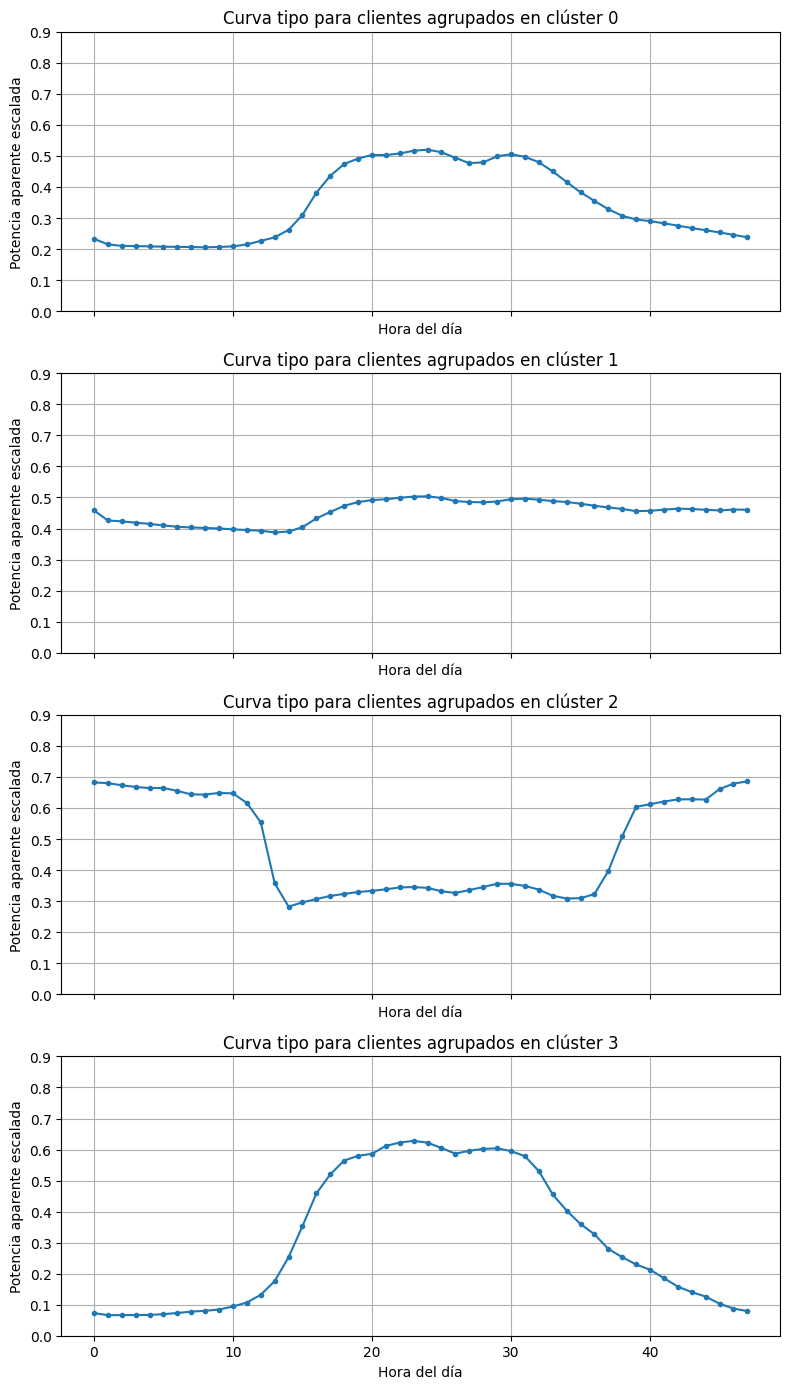

In [37]:
graficar_curva_tipo_cluster(curves_data, clusters["GaussianMixture"])

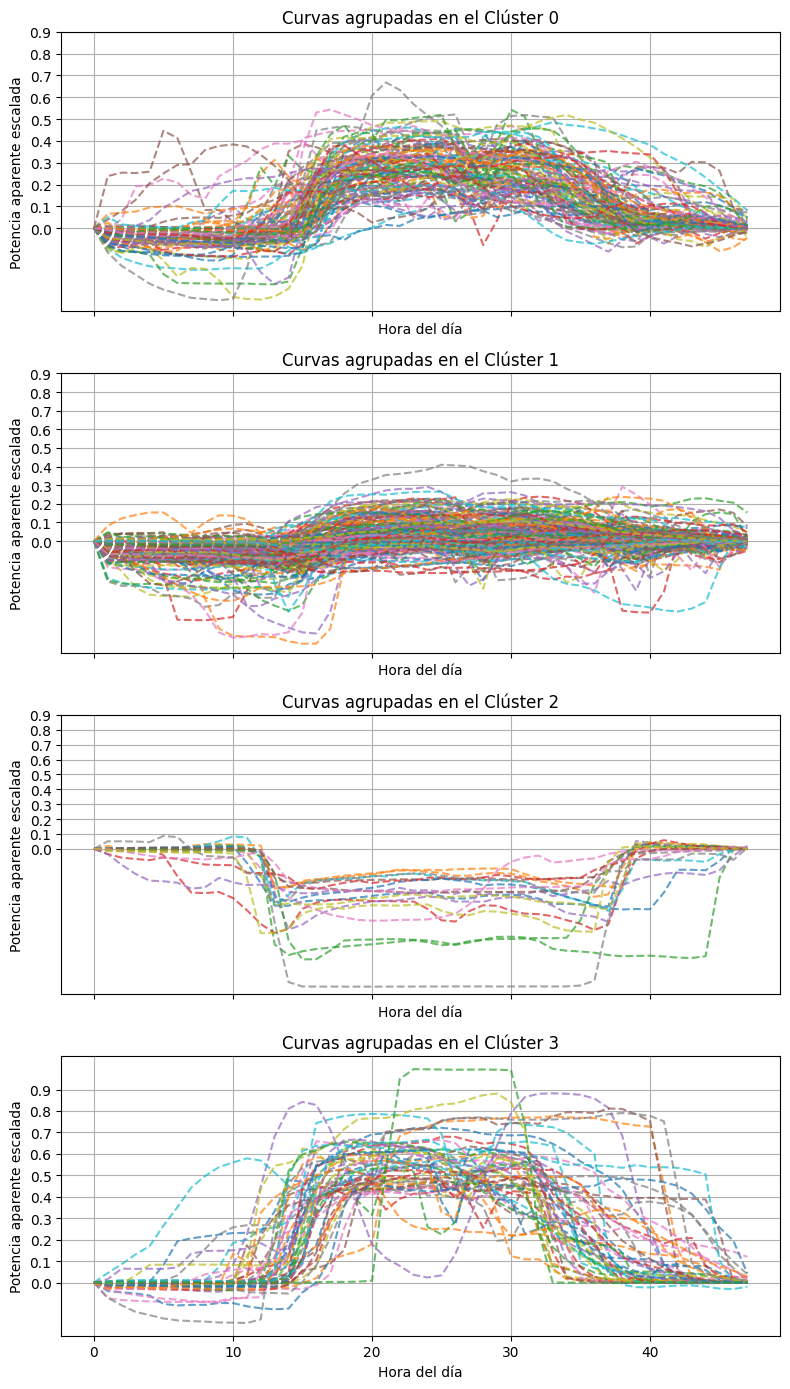

In [38]:
graficar_clusters(curvas_ajustadas_origen, clusters["GaussianMixture"], 200)

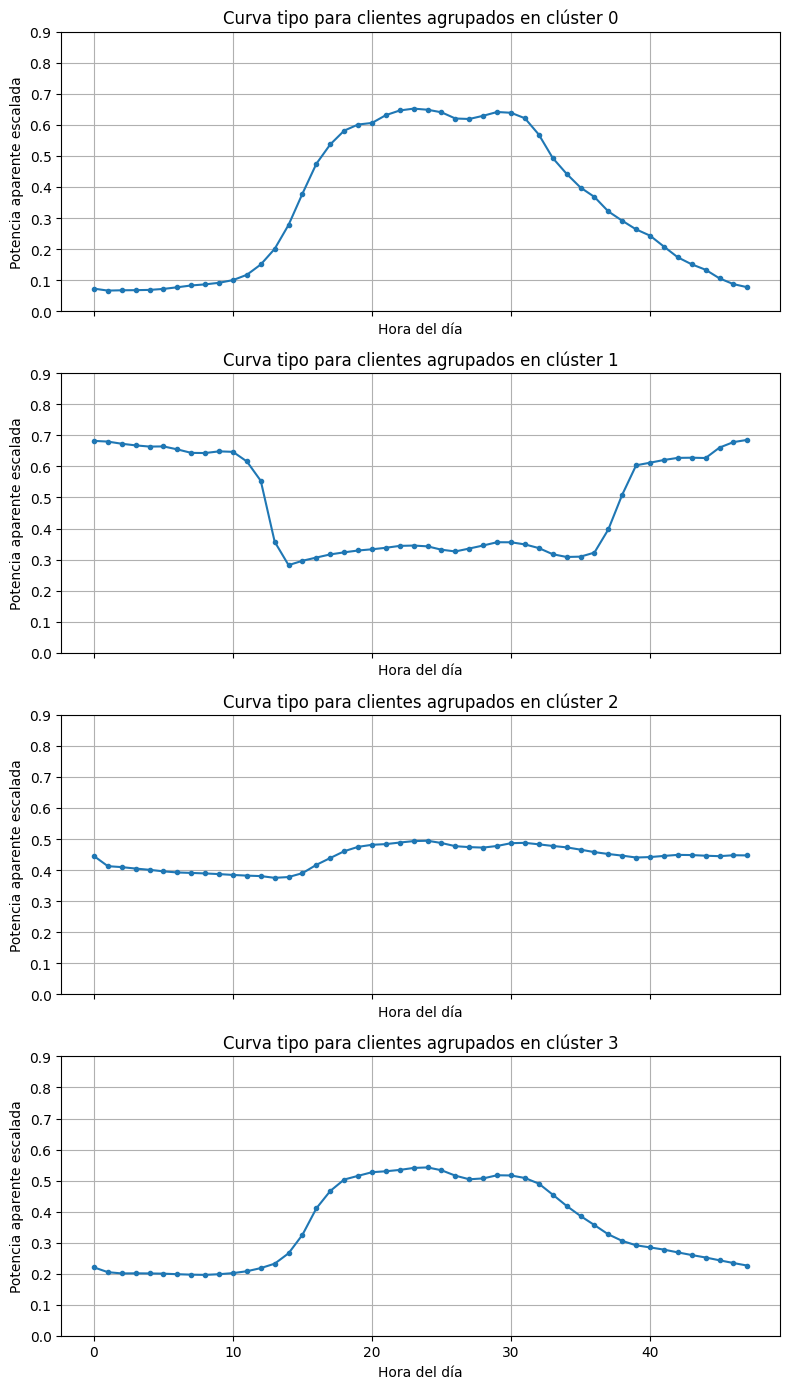

In [39]:
graficar_curva_tipo_cluster(curves_data, clusters["Birch"])

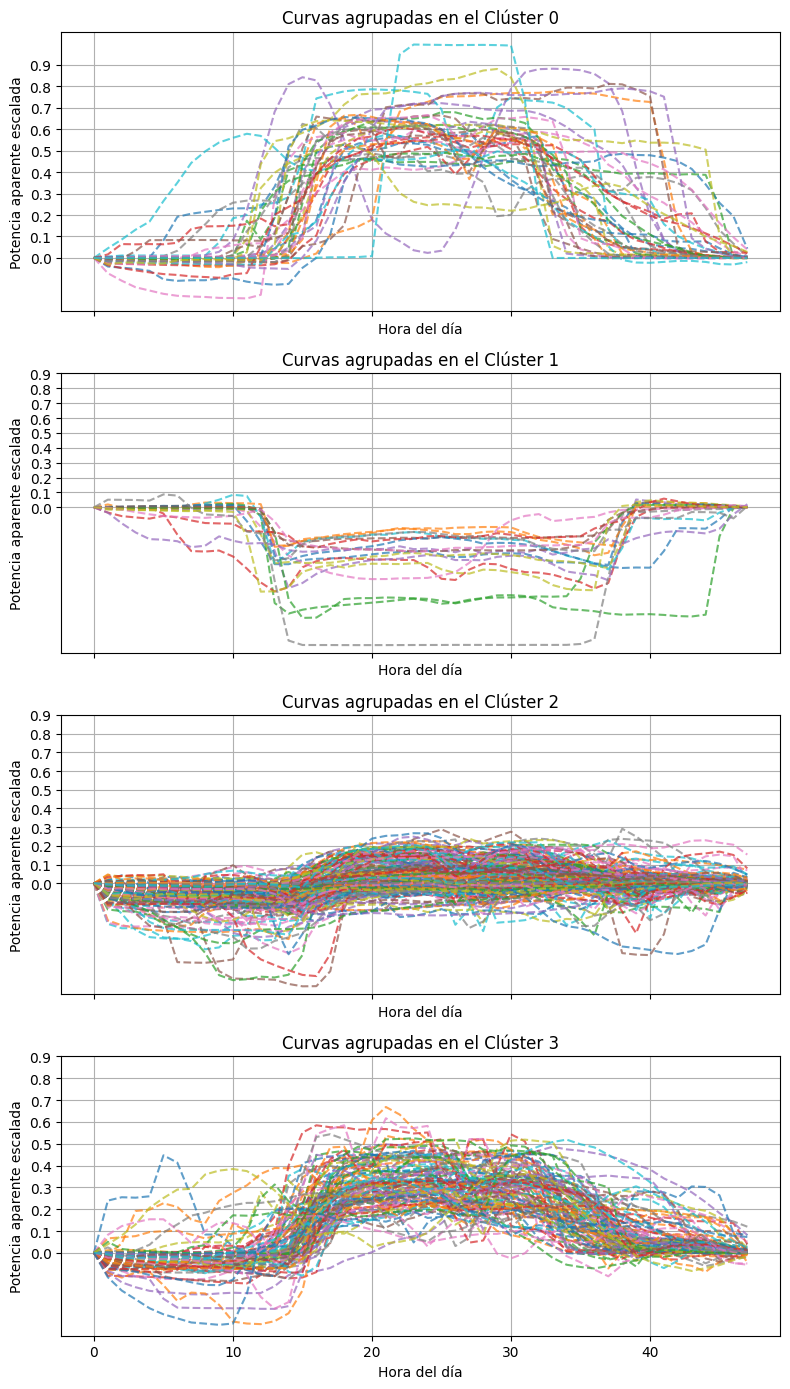

In [40]:
graficar_clusters(curvas_ajustadas_origen, clusters["Birch"], 200)

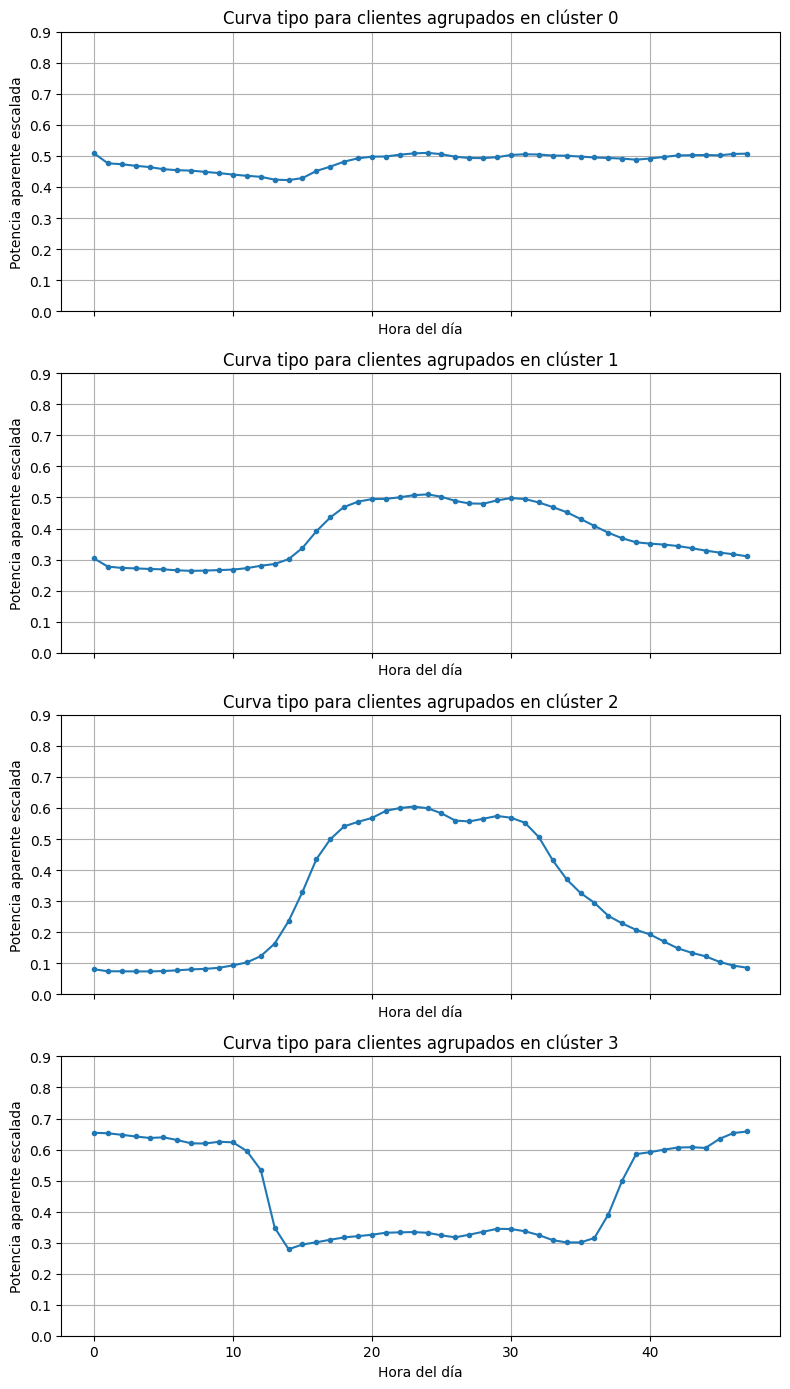

In [41]:
graficar_curva_tipo_cluster(curves_data, clusters["Spectral"])

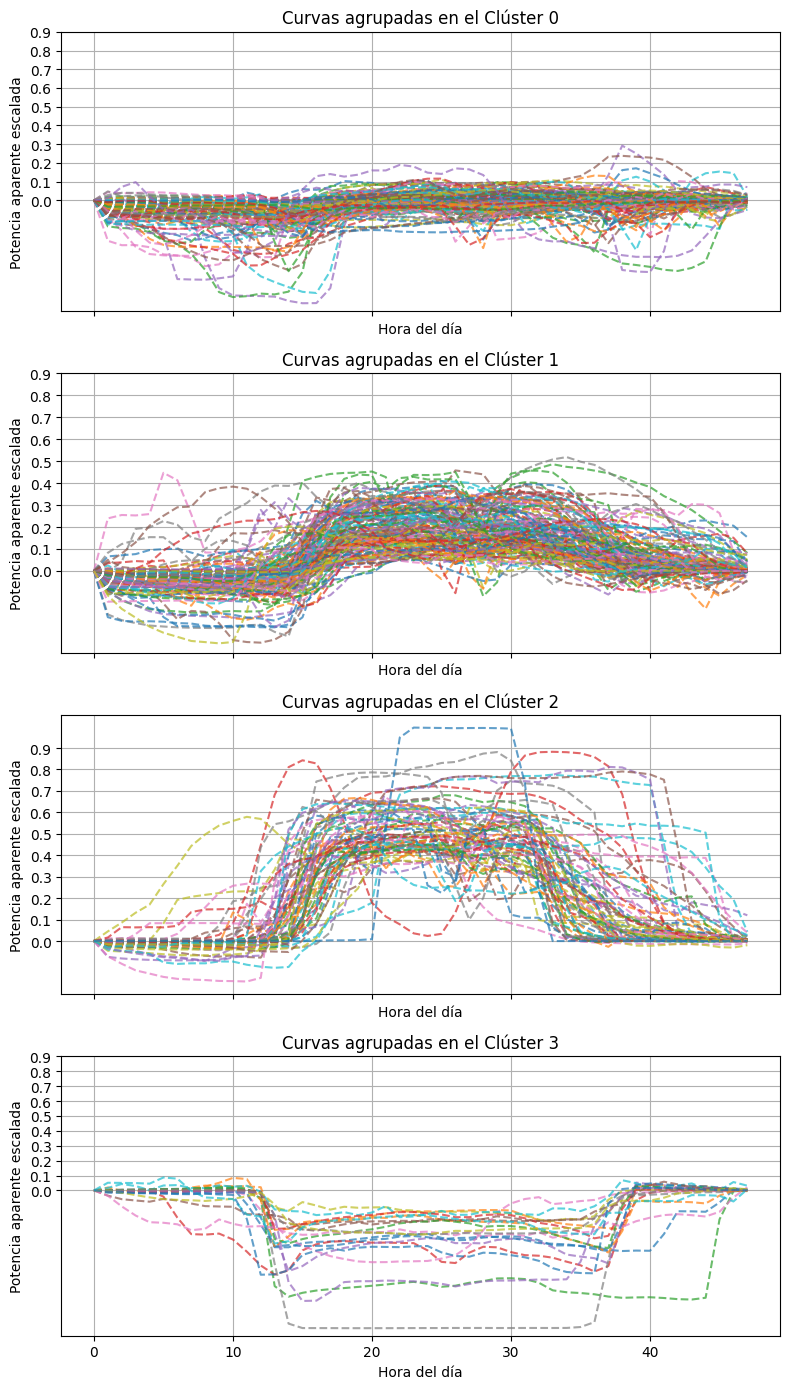

In [42]:
graficar_clusters(curvas_ajustadas_origen, clusters["Spectral"], 200)

### 6.- Comparación de Algoritmos
Se construirá una **tabla comparativa** que contendrá los siguientes indicadores de desempeño:

- **Silhouette Score**
- **SSE (Suma de Errores Cuadráticos)**
- **DBI (Índice de Davies-Bouldin)**
- **CHI (Índice de Calinski-Harabasz)**

In [44]:
df_evaluacion_algoritmos = evaluar_clustering(curvas_ajustadas_origen, clusters)
df_evaluacion_algoritmos

,Métrica,KMeans,GaussianMixture,Birch,Spectral
0,Silhouette Score,0.359624,0.322864,0.386866,0.301450
1,SSE,163.754868,175.063985,167.657714,169.987499
2,Davies-Bouldin Index,1.031603,1.077311,1.066166,0.982839
3,Calinski-Harabasz Index,267.145257,241.640445,257.954569,252.669388


---

### Pruebas con una curva de cada tipo

Ejemplos de cada curva tipo:
- 90001730 1297988  1773847-> Trapecio invertido
- 90001692  1130655  1818407  10048266-> Montañita
- 1044341 1457182  1479849  1807768-> Lineal
- 1122395  1140407  1202633  1867926-> Trapecio